# Demonstrate membership inference attacks on means by test statistics

## Tuneable simulation parameters

In [13]:
import numpy as np
from scipy import stats
import math
np.random.seed(123)

## PARAMETERS
n_sims = 10000
n_samples = 10
k_att = 100

## Define utility functions for simulating data and calculating the test statistics

In [14]:
def synthesize(population_prob, n=1):
    """Utility function to simulate sampling from a population.
    Each column is sampled with the coin-flip probability defined in population_prob."""
    x = np.random.binomial(n=1, p=population_prob, size=(n, len(population_prob)))
    #x[x == 0] = -1  # Sometimes it is convenient in ML to recode as {-1,1}
    return x


## TEST STATISTICS
def test_homer(alice, sample_mean, population_mean):
    """Calculates the Homer test statistic"""
    test_statistic = sum(abs(alice - population_mean) - abs(alice - sample_mean))
    return test_statistic


def test_dwork(alice, sample_mean, population_mean):
    """Calculates the Dwork et al. test statistic using the population means
    Let `population_mean=referent` if using only a single individual from the population as a referent.
    """
    test_statistic = np.dot(alice-population_mean, sample_mean-population_mean)
    return test_statistic


def null_distribution(fun, population_prob, population_mean, null_sims=1000, alpha=0.05):
    """Simulates the null distribution"""
    # A null distribution and critical value generator
    hold = []

    for i in range(null_sims):
        sample_mean = synthesize(population_prob, n=n_samples).mean(axis=0)
        null_alice = synthesize(population_prob)[0]
        # referent = synthesize(population_prob)[0]

        hold.append(fun(null_alice, sample_mean, population_mean))

    null_dist_vals = np.sort(hold)[::-1]
    return {
        "nulldist": null_dist_vals,
        "critical_val": null_dist_vals[round(alpha * null_sims)]
    }

## Simple graph function for showing the distribution, partitioned by critical value

In [15]:
import matplotlib.pyplot as plt


def show_distribution(x, critical_value, title):
    """Visualize the distribution with a density plot"""

    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
    kernel = stats.gaussian_kde(x)
    support = np.linspace(min(x) - kernel.factor, max(x) + kernel.factor, num=500)
    densities = kernel(support)

    flag = support < critical_value
    max_density = max(densities)

    plt.fill_between(support[flag], densities[flag], color='#005aef80')
    plt.fill_between(support[~flag], densities[~flag], color='#ef5c0080')
    plt.axvline(x=critical_value)
    plt.text(x=critical_value, y=0.8*max_density, s=" OUT", horizontalalignment='left')
    plt.text(x=critical_value, y=0.8*max_density, s="IN ", horizontalalignment='right')
    plt.text(x=critical_value, y=0.7*max_density, s=f' {(x > critical_value).mean():.2}', horizontalalignment='left')
    plt.title(title)
    plt.xlabel("Test Statistic")
    plt.ylabel("Density")
    plt.show()

## Simulate and graph a null distribution

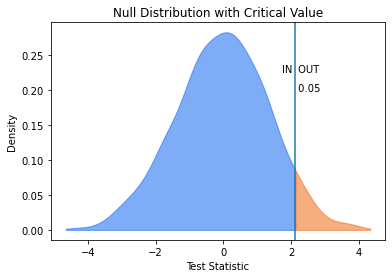

In [16]:
# Generate underlying population attributes
population_prob = np.random.uniform(size=k_att)
population_mean = population_prob 
# population_mean = 2*population_prob - 1.  # If we are recoding to {-1,1} in next function

# Find the null distribution
output = null_distribution(test_homer, population_prob, population_mean)
testdist = output["nulldist"]
criticalValue = output["critical_val"]
show_distribution(testdist, criticalValue, title="Null Distribution with Critical Value")
plt.show()

## Here is our core simulation.  We are going to iterate across datasets, calculate the discrimination of the test statistic among observations in the private data and the null population.

In [17]:
## SIMULATE 

# of length n_sims, with 4 values in each
history = np.zeros(shape=(n_sims, 4))

alpha = 0.01
# Find null distributions
nullDist_Homer = null_distribution(test_homer, population_prob, population_mean, alpha=alpha)
nullDist_Dwork = null_distribution(test_dwork, population_prob, population_mean, alpha=alpha)

for i in range(n_sims):
    # Simulate data
    sample = synthesize(population_prob, n=n_samples)
    sample_mean = sample.mean(axis=0)
    alice = sample[0]
    null_alice = synthesize(population_prob, n=1)[0]
    # referent = synthesize(population_prob, n=1)[0]

    # Store simulated values
    history[i, :] = [
        # homer statistics
        test_homer(alice=alice, sample_mean=sample_mean, population_mean=population_mean), 
        test_homer(alice=null_alice, sample_mean=sample_mean, population_mean=population_mean), 

        # dwork statistics
        test_dwork(alice=alice, sample_mean=sample_mean, population_mean=population_mean), 
        test_dwork(alice=null_alice, sample_mean=sample_mean, population_mean=population_mean)
    ]

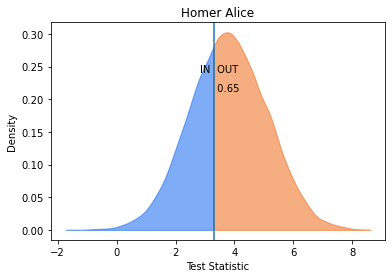

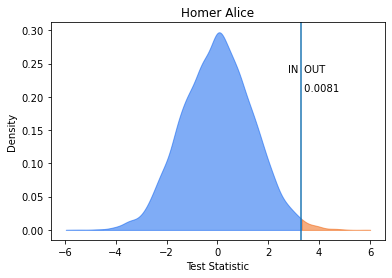

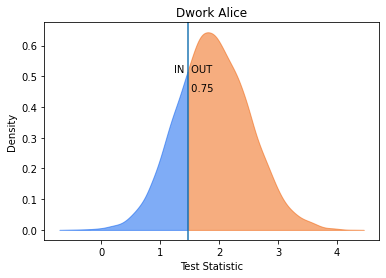

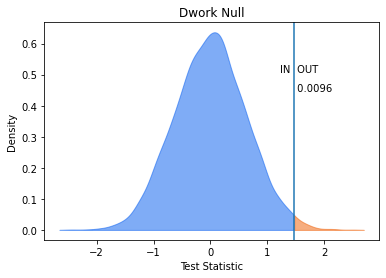

In [18]:
show_distribution(history[:, 0], critical_value=nullDist_Homer["critical_val"], title="Homer Alice")
show_distribution(history[:, 1], critical_value=nullDist_Homer["critical_val"], title="Homer Alice")

show_distribution(history[:, 2], critical_value=nullDist_Dwork["critical_val"], title="Dwork Alice")
show_distribution(history[:, 3], critical_value=nullDist_Dwork["critical_val"], title="Dwork Null")

# Tvalue = math.sqrt(8 * k_attributes * math.log(1 / alpha))
# ax1.avxline(Tvalue, color="red")
# ax2.avxline(Tvalue, color="red")

## We can expand this simulation by iterating across the number of features available

In [19]:
## SIMULATE WITH VARYING NUMBER OF FEATURES

# of length n_sims, with 4 values in each

log_seq = np.linspace(start=math.log10(10), stop=math.log10(500), num=15)
k_seq = (10**log_seq).astype(int)
print(k_seq)

all_history = np.zeros(shape=(len(k_seq), 3))

alpha = 0.01


for j, k_att in enumerate(k_seq):
    print(f"{j+1} of {len(k_seq)}: {k_att}")

    pop_prob = np.random.uniform(size=k_att)
    pop_mean = pop_prob
    #pop_mean = 2 * pop_prob - 1.  # If we are recoding to {-1,1} in next function

    # Find null distributions
    nullDist_Homer = null_distribution(test_homer, pop_prob, pop_mean, alpha=alpha)
    nullDist_Dwork = null_distribution(test_dwork, pop_prob, pop_mean, alpha=alpha)

    critical_value_Homer = nullDist_Homer["critical_val"]
    critical_value_Dwork = nullDist_Dwork["critical_val"]


    temp_history = np.zeros(shape=(n_sims, 2))

    for i in range(n_sims):
        # Simulate data
        sample = synthesize(population_prob=pop_prob, n=n_samples)
        sample_mean = sample.mean(axis=0)
        alice = sample[0]
        null_alice = synthesize(population_prob=pop_prob, n=1)[0]
        # referent = synthesize(population_prob=pop_prob, n=1)[0]

        # Store simulated values
        temp_history[i, :] = [
            # homer statistics
            test_homer(alice=alice, sample_mean=sample_mean, population_mean=pop_mean), 
            # dwork statistics
            test_dwork(alice=alice, sample_mean=sample_mean, population_mean=pop_mean) 
        ]

    homer_membership_success_rate = (temp_history[:,0] > critical_value_Homer).mean() 
    dwork_membership_success_rate = (temp_history[:,1] > critical_value_Dwork).mean()

    all_history[j, :] = [
        k_att,
        homer_membership_success_rate,
        dwork_membership_success_rate,
    ]


[ 10  13  17  23  30  40  53  70  93 123 163 216 285 378 499]
1 of 15: 10
2 of 15: 13
3 of 15: 17
4 of 15: 23
5 of 15: 30
6 of 15: 40
7 of 15: 53
8 of 15: 70
9 of 15: 93
10 of 15: 123
11 of 15: 163
12 of 15: 216
13 of 15: 285
14 of 15: 378
15 of 15: 499


In [20]:
all_history

array([[1.000e+01, 9.060e-02, 7.320e-02],
       [1.300e+01, 5.220e-02, 7.350e-02],
       [1.700e+01, 1.175e-01, 1.361e-01],
       [2.300e+01, 1.494e-01, 1.569e-01],
       [3.000e+01, 1.296e-01, 2.714e-01],
       [4.000e+01, 2.549e-01, 2.289e-01],
       [5.300e+01, 3.579e-01, 4.048e-01],
       [7.000e+01, 4.767e-01, 6.301e-01],
       [9.300e+01, 5.917e-01, 7.197e-01],
       [1.230e+02, 7.146e-01, 7.964e-01],
       [1.630e+02, 8.678e-01, 9.350e-01],
       [2.160e+02, 8.968e-01, 9.712e-01],
       [2.850e+02, 9.850e-01, 9.942e-01],
       [3.780e+02, 9.958e-01, 9.993e-01],
       [4.990e+02, 9.998e-01, 1.000e+00]])

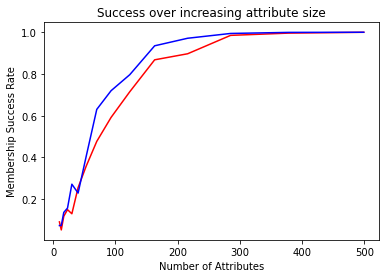

In [21]:
plt.plot(all_history[0:len(k_seq),0], all_history[0:len(k_seq),1], color="red")
plt.plot(all_history[0:len(k_seq),0], all_history[0:len(k_seq),2], color="blue")
plt.xlabel("Number of Attributes")
plt.ylabel("Membership Success Rate")
plt.title("Success over increasing attribute size")
plt.show()

In [22]:
import pandas as pd

data: pd.DataFrame = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5reconstruction.csv")
target = "uscitizen"

pub = ["sex", "age", "educ", "latino", "black", "asian",
       "married", "divorced", "children", "disability",
       "militaryservice", "employed", "englishability"]

In [23]:
def execute_means_exact(predicates):
    return data[target].values @ np.stack([pred(data) for pred in predicates], axis=1)/len(data)


def make_random_predicate():
    """Returns a (pseudo)random predicate function by hashing public identifiers."""
    prime = 691
    desc = np.random.randint(prime, size=len(pub))
    # this predicate maps data into a 1-d ndarray of booleans
    #   (where `@` is the dot product and `%` modulus)
    return lambda data: ((data[pub].values @ desc) % prime % 2).astype(bool)


In [24]:
def membership_attack(predicates, answers, alice, pop_params):
    sample_mean = execute_means_exact(predicates)
    population_mean = 2 * pop_params - 1.
    
    output = null_distribution(test_dwork, pop_params, population_mean)
    testdist = output['nulldist']
    critical_value = output['critical_val']
    
    test_statistic = test_dwork(alice=alice, sample_mean=sample_mean, population_mean=population_mean)
    dwork_membership_success = (test_statistic>critical_value)
    
    return dwork_membership_success

In [25]:
num_trials = 100
num_predicates = np.arange(2, 6) * len(data)
fp_results = []
tp_results = []

for j in range(0, len(num_predicates)):
    fp = 0
    tp = 0
    for i in range(num_trials):
        predicates = [make_random_predicate() for _ in range(num_predicates[j])]
        d = len(predicates)
        sample_mean = execute_means_exact(predicates)
        pop_params = np.random.uniform(0.5, 1, d)
        alice = synthesize(sample_mean, n=1)[0]
        null_alice = synthesize(pop_params, n=1)[0]
        she_in = membership_attack(predicates, _, null_alice, pop_params)
        fp += she_in==True
        she_in = membership_attack(predicates, _, alice, pop_params)
        tp += she_in==True
    fp_results.append(fp/num_trials)
    tp_results.append(tp/num_trials)
    print(fp_results)
    print(tp_results)
        

[0.0]
[1.0]
[0.0, 0.0]
[1.0, 1.0]
[0.0, 0.0, 0.0]
[1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0]
[1.0, 1.0, 1.0, 1.0]


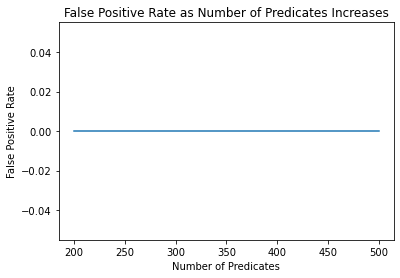

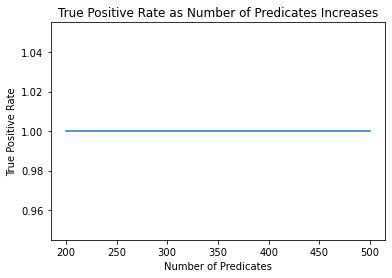

In [26]:
import matplotlib.pyplot as plt

plt.plot(num_predicates, fp_results)
plt.xlabel("Number of Predicates")
plt.ylabel("False Positive Rate")
plt.title("False Positive Rate as Number of Predicates Increases")
plt.show()

plt.plot(num_predicates, tp_results)
plt.xlabel("Number of Predicates")
plt.ylabel("True Positive Rate")
plt.title("True Positive Rate as Number of Predicates Increases")
plt.show()

In [29]:
def execute_means_exact(dat, predicates):
    """Evaluate predicates on the dataset 'dat' and return the means."""
    return dat[target].values @ np.stack([pred(dat) for pred in predicates], axis=1)/len(dat)

def membership_attack(answers, alice, pop_params):
    """Perform membership attack using dwork et al. test statistic.
    :return: True if alice is in data."""

    population_mean = 2 * pop_params - 1. 

    output = null_distribution(test_dwork, pop_params, population_mean)
    critical_value = output["critical_val"]

    # membership attack here
    test_statistic = test_dwork(alice=alice, sample_mean=answers, population_mean=population_mean)
    dwork_membership_success = (test_statistic > critical_value)
    return dwork_membership_success

In [ ]:
import time

small_data: pd.DataFrame = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")\
    .sample(n=100)

num_trials = 1000
fp_results = []
tp_results = []

num_predicates = np.arange(2, 6) * len(small_data)
for d in num_predicates:
    fp = 0
    tp = 0

    print('Predicate space dimensionality:', d)

    start_time = time.time()
    for i in range(num_trials):
        
        # regenerate predicates for each trial
        predicates = [make_random_predicate() for _ in range(d)]

        sample_mean = execute_means_exact(small_data, predicates)

        # alice is in the sample (Fulton) and null_alice is from the population (U.S.)
        # use the following population parameters
        # (imagine whole of U.S. is the population and Fulton is below it so we see a clear signal)
        pop_params = np.random.uniform(0.5, 1.0, d)

        null_alice = synthesize(population_prob=pop_params, n=1)[0]
        fp += membership_attack(sample_mean, null_alice, pop_params)

        alice = synthesize(population_prob=sample_mean, n=1)[0]
        tp += membership_attack(sample_mean, alice, pop_params)

    print(f"{time.time() - start_time} seconds")
    fp_results.append(fp / num_trials)
    tp_results.append(tp / num_trials)

print(fp_results)
print(tp_results)

Predicate space dimensionality: 200
387.24075078964233 seconds
Predicate space dimensionality: 300
553.8914272785187 seconds
Predicate space dimensionality: 400
667.840245962143 seconds
Predicate space dimensionality: 500


In [ ]:
import matplotlib.pyplot as plt

plt.plot(num_predicates, fp_results)
plt.xlabel("Number of Predicates")
plt.ylabel("False Positive Rate")
plt.title("False Positive Rate as Number of Predicates Increases")
plt.show()

plt.plot(num_predicates, tp_results)
plt.xlabel("Number of Predicates")
plt.ylabel("True Positive Rate")
plt.title("True Positive Rate as Number of Predicates Increases")
plt.show()